In [1]:
import numpy as np
from numpy.linalg import norm,inv,slogdet,matrix_rank
from numpy import array,trace,diag,zeros,ones,full,einsum,sqrt
from copy import deepcopy

from scipy.optimize import minimize
from scipy.stats import multivariate_normal,chi2
from scipy.special import expit

import itertools
import copy
from joblib import Parallel, delayed
from tqdm import tqdm_notebook
from collections import deque

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle,Ellipse
import imageio

import sys
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal, MultivariateNormal
from time import time

from range_sensor_utils import RangingSensors,RangeSensorTorchUtils

In [2]:
#setting constant
range_u_s = [-0.15,0.15]
range_u_t = [-0.001,0.001]

#default is range sensor
sensor_helper = RangeSensorTorchUtils()
sensor_simulator = RangingSensors(zeros((4,3)))

# Setting I: Range-based 2D sensor
### Stats of observations $x$, for cost function, including
$$\mu(\theta),C(\theta),C(\theta)\prime,\mu(\theta)\prime,C(\theta)^{-1}$$

* $\mathbf{\theta}$ is a random variable which denotes target location.  
* $\textbf{z}$ denotes sensor location. 
* $\textbf{x}$ denotes observation, which depends on both sensors' location and taget location, $\textbf{x} \sim N(\mu(\theta),C(\theta))$

* M sensors and each gives one observation, 1-dimensional range observation, N-dimensional space

$$i,k \in (1,\dots,N)$$
$$ j \in (1,\dots, M)$$

* $\mu(\mathbf{\theta}): (N \times 1)$


    * 2D transition case:
    * $$\mu(\mathbf{\theta})_i = ||\mathbf{\theta}-s_i||_2$$ 
    * $$[\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta}_j}]_{i} = \frac{\theta_j-s_{ij}}{||\mathbf{\theta}-s_i||_2}$$
    * $$ C(\mathbf{\theta})_{ii} = \sigma^2(1+\alpha\mu(\mathbf\theta)_i^2)$$
    * $$[\frac{\partial{C(\mathbf{\theta})}}{\partial{\theta}_j}]_{ii} = 2\alpha\sigma^2 (\theta_{j}-s_{ij})$$
    
    * 4D transition case 1:
    * $$\mu(\mathbf{\theta})_i = ||e^\top\mathbf{\theta}-e^\top s_i||_2$$ 
    * $$[\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta}_j}]_{i} = \frac{ee^\top\theta_j-ee^\top s_{ij}}{||e^\top\mathbf{\theta}-e^\top s_i||_2}$$
    * $$ C(\mathbf{\theta})_{ii} = \sigma^2(1+\alpha\mu(\mathbf\theta)_i^2)$$
    * $$[\frac{\partial{C(\mathbf{\theta})}}{\partial{\theta}_j}]_{ii} = 2\alpha\sigma^2 (ee^\top\theta_{j}-ee^\top s_{ij})$$
    
    * 4D transition case 2:
    * $$\mu(\mathbf{\theta})_i = ||e^\top A\mathbf{\theta}-e^\top s_i||_2$$ 
    * $$[\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta}_j}]_{i} = \frac{A^\top ee^\top (A\theta_j-s_{ij})}{||e^\top A\mathbf{\theta}-e^\top s_i||_2}$$
    * $$ C(\mathbf{\theta})_{ii} = \sigma^2(1+\alpha\mu(\mathbf\theta)_i^2)$$
    * $$[\frac{\partial{C(\mathbf{\theta})}}{\partial{\theta}_j}]_{ii} = 2\alpha\sigma^2 (A^\top ee^\top(A\theta_{j}-s_{ij}))$$


## Maximum-Likelihood Estimator & Fisher Infomation & Cramer Rao Lower Bound

* MLE

$$ f(X;\theta) = (2\pi)^{-\frac{M}{2}}|Cov(\theta)|^{-\frac{1}{2}}\exp\{-\frac{1}{2}(X-\mu(\theta))^\top Cov(\theta)^{-1}(X-\mu(\theta))\}$$
$$l = \log{f(X;\theta)} = C - \frac{1}{2}log |Cov(\theta)| -\frac{1}{2}(X-\mu(\theta))^\top Cov(\theta)^{-1}(X-\mu(\theta))$$

* Fisher Information, $\textrm{I}(\mathbf{\theta}): (M\times M)$

$${\mathcal {I}}(\theta )=\operatorname {E} \left[\left.\left({\frac {\partial }{\partial \theta }}\log f(X;\theta )\right)^{2}\right|\theta \right]=\int _{\mathbb {R} }\left({\frac {\partial }{\partial \theta }}\log f(x;\theta )\right)^{2}f(x;\theta )\,dx$$

$$[\textrm{I}(\mathbf{\theta})_{ik}] = (\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta_i}})^\top C^{-1}(\mathbf{\theta})(\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta_k}}) + \frac{1}{2}\textrm{tr}\{C^{-1}(\mathbf{\theta})\frac{\partial{C{(\mathbf{\theta})}}}{\partial{\theta_i}}C^{-1}(\mathbf{\theta})\frac{\partial{C{(\mathbf{\theta})}}}{\partial{\theta_k}}\}$$

* CRLB
$$CRLB = \mathcal{I(\theta)}^{-1}$$

In [3]:
def observe(mu,cov,size=1): 
    return multivariate_normal.rvs(mean=mu, cov=cov, size=size)

In [4]:
def neglog_gaussian(obs,mu,cov):
    inv_cov = inv(cov)
    muo = obs-mu
    if len(obs.shape)>1:
        ma = einsum('ik,ii->ik',muo.T,inv_cov)
        ll = einsum('ik,ki->k',ma,muo).sum() + n_obs * slogdet(cov)[1]
    else:
        ll = muo.T@inv_cov@muo + slogdet(cov)[1]
    return ll

def fun_mle_gaussian_1(*params):
    x,obs,sim = params
    x = array([x]).T
    mu = sim.hx(x)
    cov = sim.sx(x)
    ll = neglog_gaussian(obs,mu,cov)
    return ll

def fun_mle_gaussian_2(*params):
    x,obs,sim,obs_prev,sim_prev = params
    
    x = array([x]).T
    mu_prev = sim_prev.hx(x)
    cov_prev = sim_prev.sx(x)
    ll_prev = neglog_gaussian(obs_prev,mu_prev,cov_prev)
    
    x1 = AA@x
    mu = sim.hx(x1)
    cov = sim.sx(x1)
    ll = neglog_gaussian(obs,mu,cov)
    
    return ll + ll_prev

def fisher_information(mu,cov,d_mu,d_cov):
    inv_cov = inv(cov)
    M = d_mu.shape[1]
    I = zeros((M,M))
    for i in range(M):
        for j in range(M):
            I[i,j] = d_mu[:,[i]].T@inv_cov@d_mu[:,[j]] + 0.5*np.trace(inv_cov@d_cov[i,:,:]@inv_cov@d_cov[j,:,:])
    return I

def crlb(*args):
    f = fisher_information(*args)
    lb = zeros(f.shape)
    J = np.inf
    if matrix_rank(f) == f.shape[0]:
        lb = inv(f)
        J = trace(lb)
    return J

In [5]:
def estimate_mle(rs,obs,initial_guess):
    est = minimize(fun_mle_gaussian_1,x0=initial_guess,args=(obs,rs),method='TNC',options={'ftol':1e-16}).x.reshape(-1,1)
         
    #variance bound of estimator
    fi = fisher_information(rs.hx(est),rs.sx(est),rs.H(est),rs.S(est))
    
    err = sqrt(diag(inv(fi[:2,:2]))*chi2.ppf(0.95, 1))
    return est,err

## System Dynamics

### I: velocity as control
* $\textbf{x}$ denotes state, $\textbf{u}$ denotes control, $\textbf{a}$ denotes adversarial disturbance
 $$\textbf{x}_k = \left(\begin{array}{c}\textbf{x}_k^s\\ 
\textbf{x}_k^t\end{array}\right),\textbf{x}_k^s = [p], \textbf{x}_k^s = \textbf{x}_{k-1}^s + \textbf{u}_k, \textbf{x}_k^t = \textbf{x}_{k-1}^t + \textbf{a}_k$$

### II: acceleration as control
 $$\textbf{x}_k = \left(\begin{array}{c}\textbf{x}_k^s\\ 
\textbf{x}_k^t\end{array}\right),\textbf{x}_k^s = [p,v], \textbf{x}_k^s = \textbf{Ax}_{k-1}^s + \textbf{Bu}_k, \textbf{x}_k^t = \textbf{Ax}_{k-1}^t + \textbf{Ba}_k$$

## Cost function

In [6]:
def fisher_information_torch(mu,cov,d_mu,d_cov):
    inv_cov = torch.linalg.inv(cov)
    M = d_mu.shape[1]
    I = torch.zeros((M,M))
    for i in range(M):
        for j in range(M):
            I[i,j] = d_mu[:,[i]].T@inv_cov@d_mu[:,[j]] + 0.5*torch.trace(inv_cov@d_cov[i,:,:]@inv_cov@d_cov[j,:,:])
    return I

def crlb_torch(*args):
    f = fisher_information_torch(*args)
    lb = torch.zeros(f.shape)
    J = torch.inf
    if torch.linalg.matrix_rank(f) == f.shape[0]:
        lb = torch.linalg.inv(f)
        J = torch.trace(lb)
    return sensor_helper.rescale(J)

## Auto Grad

In [7]:
def reparam(u,lower,upper): #reparameterize
    #print((torch.sigmoid(u)).shape,(upper-lower).shape)
    return torch.sigmoid(u).mul(upper-lower)+lower
    
def forward(x_s,x_t,u_s,u_t,v,uncertainty,w):
    u_s_shape = u_s.shape
    u_t_shape = u_t.shape
    
    #time horizon T
    T = u_t_shape[0]
    #print('?',v.shape,uncertainty.shape)
    #deal with uncertain
    if v.requires_grad:
        v = reparam(v,uncertainty[:,[0]],uncertainty[:,[1]])
    #print('?',v.shape)
    #reparameterize
    if u_s.requires_grad:
        u_s = reparam(u_s,*range_u_s)
    
    if u_t.requires_grad:
        u_t = reparam(u_t,*range_u_t)
    
    #initialize variables
    L = torch.zeros(T)
    x_s_ = torch.zeros(u_s_shape)
    x_t_ = torch.zeros(u_t_shape)
    
    for k in range(T):
        if k == 0:
            x_s_[k] = sensor_helper.transition(x_s,u_s[k])
            #print(x_t.shape,v.shape)
            x_t_[k] = sensor_helper.transition(x_t+v,u_t[k])
        else:
            x_s_[k] = sensor_helper.transition(x_s_[k-1],u_s[k])
            x_t_[k] = sensor_helper.transition(x_t_[k-1],u_t[k])
        
        #step cost
        mu = sensor_helper.hx(x_t_[k],x_s_[k])
        cov = sensor_helper.sx(x_t_[k],x_s_[k])
        d_mu = sensor_helper.H(x_t_[k],x_s_[k])
        d_cov = sensor_helper.S(x_t_[k],x_s_[k])
        L[k] = crlb_torch(mu,cov,d_mu,d_cov)
    #print(L)
    return torch.dot(L,w)

## Gradient Descent

In [8]:
def train_gradient_descent(optimizer,x_s,x_t,u_s,u_t,v,uncertainty,w):
    optimizer.zero_grad()
   
    loss = forward(x_s,x_t,u_s,u_t,v,uncertainty,w)
    
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        loss_val = loss.item()
            
    return loss_val

In [9]:
def greedymove(x_s,x_t,lr,is_target=True,maxi = True,n_iter = 600):
    s_shape = x_s.shape
    t_shape = x_t.shape
    
    T = 1
    #plan counter move first
    u_s = torch.tensor(0.001*np.random.randn(T,*s_shape), requires_grad = not(is_target))
    u_t = torch.tensor(0.001*np.random.randn(T,*t_shape), requires_grad = is_target)
    v = torch.zeros(t_shape)
        
    losses = []
    
    opt = optim.Adam([u_t if is_target else u_s],lr = lr)
    
    if maxi:
        opt.param_groups[0]['lr'] *= -1 #change descending to ascending
    
    for i in range (n_iter):
        loss_val = train_gradient_descent(opt,x_s,x_t,u_s,u_t,v,zeros(t_shape[0]),torch.ones(T))
        losses.append(loss_val)
        #print(loss_val)
        if loss_val==np.inf:
            break
            
    
    if is_target:
        u = reparam(u_t.detach(),*range_u_t)
    else:
        u = reparam(u_s.detach(),*range_u_s)
        
    return u,losses

In [10]:
#Settings

range_u_s = [-0.15,0.15]
range_u_t = [-0.1,0.1]
lr_t = 0.01
xs = np.array([[-2.9414, -1.3868,-1,1], [-2.5536, -0.6925,0,1],[-1.4836,  0.4326,0.5,0.5]]).T
xt = np.array([[-1.9170, -0.9756, 1,1]]).T

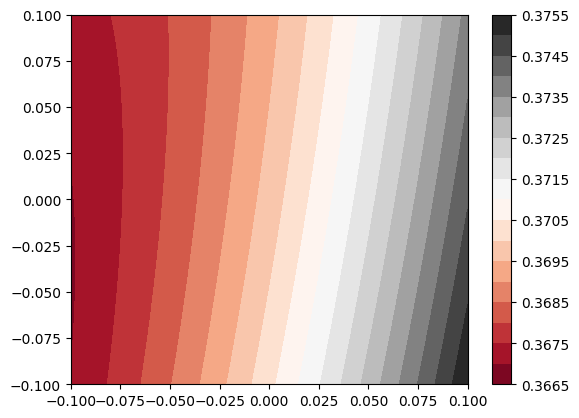

In [11]:
X,Y = np.mgrid[-0.1:0.105:0.005, -0.1:0.105:0.005]
N,M = X.shape
Z = np.zeros((N,M))
rs = RangingSensors(xs)
for i in range(N):
    for j in range(M):
        u = np.array([[0,0,X[i,j],Y[i,j]]]).T
        xs_ = RangingSensors.transition(xs,zeros((4,3)))
        xt_ = RangingSensors.transition(xt,u)
        rs.states = xs_
        Z[i,j] = crlb(rs.hx(xt_),rs.sx(xt_),rs.H(xt_)[:,:2],rs.S(xt_)[:2,:,:])
            
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()
plt.show()

In [12]:
u_t,losses = greedymove(torch.tensor(xs),torch.tensor(xt),lr_t,is_target=True,maxi=True)
u_t

tensor([[[ 5.9978e-05],
         [-3.9081e-05],
         [ 9.4912e-02],
         [-9.5508e-02]]])

In [13]:
u_t,losses = greedymove(torch.tensor(xs),torch.tensor(xt),lr_t,is_target=True,maxi=False)
u_t

tensor([[[-1.1098e-05],
         [-4.0358e-05],
         [-9.0719e-02],
         [-1.0390e-02]]])

In [14]:
u_s,losses = greedymove(torch.tensor(xs),torch.tensor(xt),lr_t,is_target=False,maxi=False)
u_s

tensor([[[-1.0601e-04,  2.2617e-05, -1.0851e-04],
         [-2.8461e-05,  4.0127e-05, -1.9776e-05],
         [ 1.4039e-01,  1.4438e-01,  1.3231e-01],
         [-1.3944e-01,  1.4361e-01,  9.4967e-02]]])

## Gradient Descent Ascent

In [11]:
def train_gradient_descent_ascent(opts,x_s,x_t,u_s,u_t,v,uncertainty,w):
    for opt in opts:
        opt.zero_grad()
    
    loss = forward(x_s,x_t,u_s,u_t,v,uncertainty,w)
    loss.backward()
    
    for opt in opts:
        opt.step()
    
    with torch.no_grad():
        loss_val = loss.item()
            
    return loss_val

def robustmove(T,x_s,x_t,lr_s,lr_t,uncertainty,w,n_iter = 800):
    s_shape = x_s.shape
    t_shape = x_t.shape
   
    u_s = torch.tensor(0.001*np.random.randn(T,*s_shape), requires_grad=True)
    u_t = torch.tensor(0.001*np.random.randn(T,*t_shape), requires_grad=True)
    #uncertainty variable
    v = torch.zeros(t_shape,requires_grad=True)
    v_reparam = torch.tensor(np.hstack([-uncertainty,uncertainty]))
    losses = []
    
    opt_t = optim.Adam([u_t,v],lr = lr_t) 
    opt_t.param_groups[0]['lr'] *= -1
    
    opt_s = optim.Adam([u_s],lr = lr_s)
    
    
    
    for i in range (n_iter):
        loss_val = train_gradient_descent_ascent([opt_s,opt_t],x_s,x_t,u_s,u_t,v,v_reparam,w)
        losses.append(loss_val)
        
    u_s_val = reparam(u_s.detach(),*range_u_s)
    
    return u_s_val,losses


def sample_actions(a_shape,range_v):
    
    #upper and lower bound of sample
    
    range_v_l,range_v_u = range_v
    N,M = a_shape
    sample_size = (3**N)**M
    if not hasattr(range_v_l ,'len'):
        range_v_l = np.full(N,range_v_l)
        
    if not hasattr(range_v_l ,'len'):
        range_v_u = np.full(N,range_v_u)
    
    samples = np.zeros((sample_size,*a_shape))
    
    v = np.zeros((N,3))
    for i in range(N):
        v[i] = [range_v_l[i],0,range_v_u[i]]#lowerbound, zero, upperbound
    
    
    sactions = [[v[j][p[j]] for j in range(N)] for p in itertools.product(*(range(3) for i in range(N)))]
    
    sactions = np.array(sactions)
   
    
    samples = [[sactions[p[j]] for j in range(M)] for p in itertools.product(*(range(9) for i in range(M)))] 
    samples = np.array(samples)
    
    return np.swapaxes(samples,1,2)

def robustmove_samp(x_s,x_t,lr_t):
    s_shape = x_s.shape
    t_shape = x_t.shape
    
    min_loss = np.inf
    
    u_s_samples = sample_actions((2,s_shape[1]),range_u_s)
    u_s_samples = torch.tensor(u_s_samples)
    n_samples = u_s_samples.shape[0]
    u_s_samples = torch.cat([torch.zeros((n_samples,2,s_shape[1])),u_s_samples],dim=1)
    
    for i in range(n_samples):
        #sample a action from the space
        u_s = u_s_samples[i]
        
        #perform counter move
        u_t,u_loss = greedymove(sensor_helper.transition(x_s,u_s),x_t,lr_t,is_target=True,maxi=True)
        
            
        if u_loss[-1]<min_loss:
            min_loss = u_loss[-1]
            u_s_ = u_s
    
    return u_s_

In [12]:
#Settings
range_u_s = [-0.0015,0.0015]
range_u_t = [-0.001,0.001]
lr_t = 0.01
lr_s = 0.03
xs = torch.tensor(np.array([[-8.16953587,  3.80545528, -0.75878328,  0.34193835],
        [-2.52959239, -7.56522616, -0.1779239 , -0.63839548],
        [13.34830813,  9.83602738,  1.38801037,  1.00381119]])).T
xt = torch.tensor(np.array([[ 2.70643286, -8.11876279,  0.2775918 , -0.87784631]])).T

In [ ]:
u_s1 = robustmove_samp(xs,xt,lr_t)

In [237]:
u_s1

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0015, -0.0015, -0.0015],
        [ 0.0015, -0.0015,  0.0015]])

In [17]:
u_s2,_ = robustmove(1,xs,xt,lr_s,lr_t,array([[0,0,0,0]]).T,torch.ones(1))

In [18]:
u_s2

tensor([[[-1.0804e-06, -1.2231e-06, -1.5770e-07],
         [-2.4168e-07, -7.1818e-07,  6.4070e-07],
         [ 1.4890e-03, -1.4883e-03, -1.4881e-03],
         [ 1.4889e-03, -1.4893e-03,  1.4872e-03]]])

## Simulation and Evaluation

In [13]:
def plotframe(T,frame,costs,rect):
    fig = plt.figure(figsize=(12,6))
    
    ax = plt.subplot(1,2,1)

    ax.add_patch(Circle((frame['target'][0,0],frame['target'][1,0]), 1, color='orange',label='target'))
    
    
    ax.add_patch(Circle((frame['est'][0,0], frame['est'][1,0]), 1, color='green',label='estimated target'))
    #TO-DO
    ax.add_patch(Ellipse((frame['est'][0,0], frame['est'][1,0]), width=2*frame['uncertainty'][0]*(10**8)*1.5, height=2*frame['uncertainty'][1]*(10**8)*1.5, alpha=0.4, color='green'))
    
    sensors = frame['sensor']
    obs = frame['obs']
    
    for m in range(len(obs)):
        c = (sensors[0,m], sensors[1,m])
        #TO-DO
        r = obs[m]*(10**8)*1.5
        #print(r)
        ax.add_patch(Circle(c, 1, color='blue'))
        ax.add_patch(Circle(c, r, color='blue',alpha=0.1))
                  
    
    plt.title(f'T={T} k={frame["k"]}')
    plt.ylim(frame['target'][1,0]-rect[2]/2,frame['target'][1,0]+rect[2]/2)
    plt.xlim(frame['target'][0,0]-rect[1]/2,frame['target'][0,0]+rect[1]/2)
    plt.legend()
    
    ax1 = plt.subplot(1,2,2)
    ax1.plot(range(1,frame['k']+1),costs[:frame['k']],label='estimation error',c='orange')
    ax1.set_ylim(min(costs),max(costs))
    ax1.set_ylabel('absolute estimation error')
    ax1.legend(loc='center left')
    ax1.set_yscale('log')
    
    plt.xlim(1,len(costs)+1)
    plt.title('Time-Cost')
    plt.xlabel('T')
    
    plt.savefig(f'./img/img_{frame["k"]}.png', 
                    transparent = False,  
                    facecolor = 'white'
                   )
    fig.clf()
    plt.close(fig)
    
def plotgif(T,frames,costs,rect,prefix):
    gif_imgs = []
    for frame in frames:
        plotframe(T,frame,costs,rect)
        gif_imgs.append(imageio.v2.imread(f'./img/img_{frame["k"]}.png'))
    
    imageio.mimsave(f'./{prefix}_T={T}.gif',gif_imgs,fps = 4)  
    
def extract_costs(frames):
    costs = []
    sensor_trac = []
    target_trac = []
    est_trac = []
    for frame in frames:
        costs.append(frame['abs_err'])
        sensor_trac.append(frame['sensor'])
        target_trac.append(frame['target'])
        est_trac.append(frame['est'])
    return costs,array(sensor_trac),array(target_trac),array(est_trac)

In [14]:
def find_symmetric(sensors,target):
    idx_sensor = np.argmin(((sensors-target)**2).sum(axis=0))
    symmetric_point = 2*sensors[:,[idx_sensor]]-target
    return symmetric_point

In [15]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [16]:
def tracking(K,T,x_s,x_t,lr_s,lr_t,w,intelligent_target=True):
    frames = []
    
    previous_est = np.random.random(x_t.shape)
    #x_s_n_prev = x_s.numpy()
    x_t_n = x_t.numpy()
    x_s_n = x_s.numpy()
    sensor_simulator.states = x_s_n
    #obs_prev = None
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    t5 = 0
    
    for k in range(K):
        frame = {}
        
        frame['target'] = x_t_n
        frame['sensor'] = x_s_n
        
        #STEP 1. read observaion
        t_a = time()
        obs = observe(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n),size=1)
        frame['obs'] = obs
        t_b = time()
        t1 += t_b - t_a
        
        #STEP 2. estimate target
        est,err = estimate_mle(sensor_simulator,obs,previous_est[:,0])
        ll = neglog_gaussian(obs,sensor_simulator.hx(est),sensor_simulator.sx(est))
        
        if isinstance(sensor_simulator,RangingSensors):
            uncertainty = np.zeros((4,1))
            another_guess = find_symmetric(x_s_n,est)
            est2,err2 = estimate_mle(sensor_simulator,obs,another_guess[:,0])
            est2 = est2
            ll2 = neglog_gaussian(obs,sensor_simulator.hx(est2),sensor_simulator.sx(est2))

            if ll2<ll:
                est = est2
                err = err2
            
            velocity = sensor_helper.estimate_velocity(est,previous_est) 
            est[2:,:] = velocity
            uncertainty[:,0] = err[[0,1,0,1]]
            
        frame['est'] = est
        frame['uncertainty'] = err
        frame['abs_err'] = sensor_helper.abs_err(x_t_n,est)
        
        
        x_s_n_prev = x_s_n.copy()
        previous_est = est.copy()
        #obs_prev = obs.copy()
        t_c = time()
        t2 += t_c-t_b
        
        #STEP 3. plan nextmove
        if T<1:
            u_s,_ = greedymove(x_s,torch.tensor(est),lr_t,is_target=False,maxi=False)
        else:
            u_s,_ = robustmove(T,x_s,torch.tensor(est),lr_s,lr_t,uncertainty,w)
        t_d = time()
        t3 += t_d-t_c
        
        #STEP 4. sensor act
        x_s = sensor_helper.transition(x_s,u_s[0])
        sensor_simulator.states = x_s.numpy()
        t_e = time()
        t4 += t_e-t_d
        
        #STEP 5. target act
        if intelligent_target:
            u_t,_ = greedymove(x_s,x_t,lr_t,is_target=True,maxi=True)
        else: #random move
            a = np.random.uniform(low=range_u_t[0], high=range_u_t[1], size=(2))
            u_t = torch.zeros((1,*x_t.shape))
            u_t[0,-1,0] = a[-1]
            u_t[0,-2,0] = a[-2]
        
        x_t = sensor_helper.transition(x_t,u_t[0])
        t_f = time()
        t5 += t_f- t_e
        #STEP 6. evaluate 
        
        
        x_t_n = x_t.numpy()
        x_s_n = x_s.numpy()
        sensor_simulator.states = x_s_n
        frame['cost'] = crlb(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n),sensor_simulator.H(x_t_n),sensor_simulator.S(x_t_n))
        frame['k'] = k

        frames.append(frame)
    print('Step 1=',t1,' Step 2=',t2,' Step 3=',t3,' Step 4=',t4,' Step 5=',t5)
    return frames  

In [37]:
K=200
range_u_s = [-0.05,0.05]
range_u_t = [-0.01,0.01]
lr_t = 0.01
lr_s = 0.03
sensor_helper = RangeSensorTorchUtils()
sensor_simulator = RangingSensors(zeros((4,4)))

xs = torch.tensor([[-4.,4.,0.,0.],[-4.,-4.,0.0,0.0],[4.,0.,0.,0.],[0.,0.,0.,0.]]).T
xt = torch.tensor([[-15.1,-15.2,-0.1,-0.1]]).T

torch.manual_seed(0)
w0 = torch.tensor([0.5.,0.5])
frames_0 = tracking(K,2,xs,xt,lr_s,lr_t,w0,intelligent_target=True)


w1 = torch.tensor([1.,0,0,0,1])
frames_1 = tracking(K,5,xs,xt,lr_s,lr_t,w1,intelligent_target=True)

frames_3 = tracking(K,5,xs,xt,lr_s,lr_t,w1,intelligent_target=False)

Step 1= 0.018360614776611328  Step 2= 4.613602876663208  Step 3= 340.1516523361206  Step 4= 0.0017580986022949219  Step 5= 79.91561961174011
Step 1= 0.018022775650024414  Step 2= 4.502597093582153  Step 3= 550.2832190990448  Step 4= 0.0018360614776611328  Step 5= 79.43161153793335
Step 1= 0.018082857131958008  Step 2= 4.507736444473267  Step 3= 552.4287931919098  Step 4= 0.0017635822296142578  Step 5= 0.006513118743896484


In [38]:
cost_0 = extract_costs(frames_0)
cost_1 = extract_costs(frames_1)
cost_3 = extract_costs(frames_3)

In [39]:
rect = [(-50,-50),200,200]

plotgif(5,frames_0,cost_0,rect,'Intelligent Target')

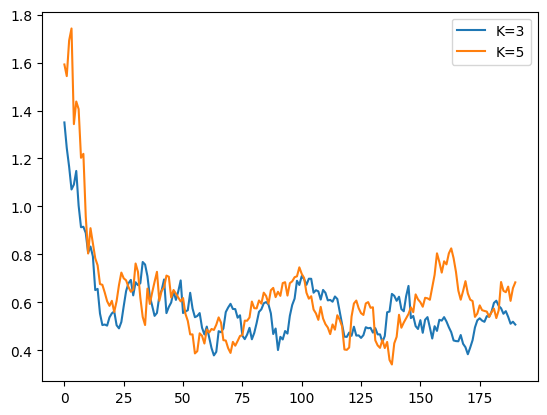

In [92]:
plt.plot(moving_average(cost_0,n=10),label='K=3')
plt.plot(moving_average(cost_1,n=10),label='K=5')
plt.legend()
plt.show()

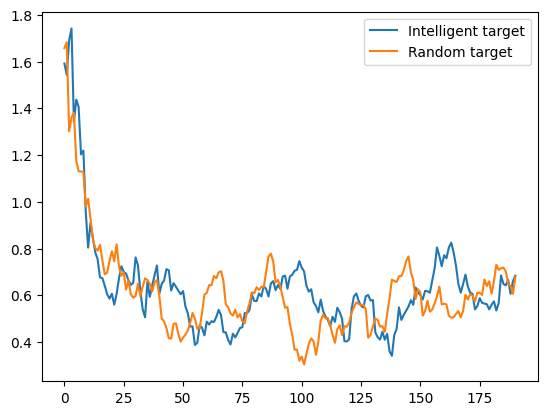

In [41]:
plt.plot(moving_average(cost_1),label='Intelligent target')
plt.plot(moving_average(cost_3),label='Random target')
plt.legend()
plt.show()

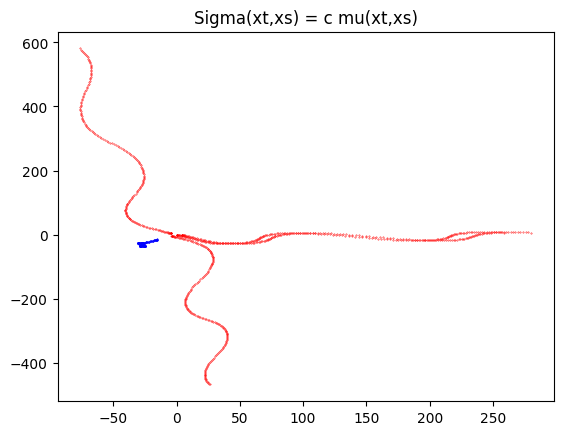

In [42]:
plt.title('Sigma(xt,xs) = c mu(xt,xs)')
for frame in frames_0:
    plt.scatter(frame['target'][0,:],frame['target'][1,:],c='blue',s=0.1)
    plt.scatter(frame['sensor'][0,:],frame['sensor'][1,:],c='red',s=0.1)

In [55]:
def smooth_trajectory(K,good=False):
    x_t = torch.zeros((4,1))
    x_t[3,:] = 1
    
    x_s = torch.zeros((4,3))
    
    
    x_s[1,0] = -5
    x_s[1,1] = -10
    x_s[1,2] = -15
    
    if good:
        x_s[0,0] = -2
        x_s[0,1] = -10
        x_s[0,2] = 5
    
    previous_est = torch.zeros(x_t.shape)
    u_t =  torch.zeros((4,K))
    u_t[2,:] = 0.01
    return x_t,x_s,u_t

In [58]:
def tracking_smooth(K,T,lr_s,lr_t,w):
    frames = []
    
    x_t,x_s,u_t = smooth_trajectory(K)
    
    previous_est = array([[-10.,3, 0, 0]]).T#This is the same initial guess as EKF
    x_t_n = x_t.numpy()
    x_s_n = x_s.numpy()
    sensor_simulator.states = x_s_n
    
    for k in range(K):
        frame = {}
        
        x_t_n = x_t.numpy()
        x_s_n = x_s.numpy()
        
        frame['target'] = x_t_n
        frame['sensor'] = x_s_n
        
        #STEP 1. read observaion
        t_a = time()
        obs = observe(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n),size=1)
        frame['obs'] = obs
        
        #STEP 2. estimate target
        est,err = estimate_mle(sensor_simulator,obs,previous_est[:,0])
        ll = neglog_gaussian(obs,sensor_simulator.hx(est),sensor_simulator.sx(est))
        
        if isinstance(sensor_simulator,RangingSensors):
            uncertainty = np.zeros((4,1))
            another_guess = find_symmetric(x_s_n,est)
            est2,err2 = estimate_mle(sensor_simulator,obs,another_guess[:,0])
            est2 = est2
            ll2 = neglog_gaussian(obs,sensor_simulator.hx(est2),sensor_simulator.sx(est2))

            if ll2<ll:
                est = est2
                err = err2
            
            velocity = sensor_helper.estimate_velocity(est,previous_est) 
            est[2:,:] = velocity
            uncertainty[:,0] = err[[0,1,0,1]]
            
        frame['est'] = est
        frame['uncertainty'] = err
        frame['abs_err'] = sensor_helper.abs_err(x_t_n,est)
        
        
        x_s_n_prev = x_s_n.copy()
        previous_est = est.copy()
        #print(est,x_t)
        
        #STEP 3. plan nextmove
        if T<1:
            u_s,_ = greedymove(x_s,torch.tensor(est),lr_t,is_target=False,maxi=False)
        else:
            u_s,_ = robustmove(T,x_s,torch.tensor(est),lr_s,lr_t,uncertainty,w)
        
        #STEP 4. sensor act
        x_s = sensor_helper.transition(x_s,u_s[0])
        x_s_n = x_s.numpy()
        sensor_simulator.states = x_s_n
        
        #STEP 5. target act
        #bound velocity
        if x_t[2,0] < 1:
            x_t = sensor_helper.transition(x_t,u_t[:,[k]])
        x_t_n = x_t.numpy()
        
        #6. evaluate 
        frame['cost'] = crlb(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n),sensor_simulator.H(x_t_n),sensor_simulator.S(x_t_n))
        
        frame['k'] = k
        
        frames.append(frame)
    return frames

In [59]:
K = 100
range_u_s = [-0.01,0.01]
range_u_t = [-0.001,0.001]
lr_t = 0.01
lr_s = 0.03
w2 = torch.tensor([0.5,0,0,0.5])
frames_2 = tracking_smooth(K,4,lr_s,lr_t,w2)


In [60]:


cost_2,sensors_2,target_2,est_2 = extract_costs(frames_2)

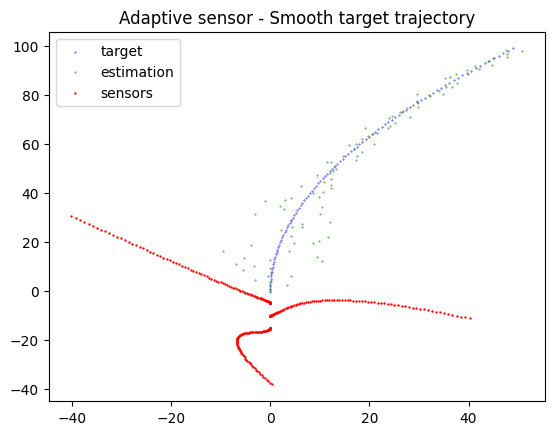

In [61]:
plt.title('Adaptive sensor - Smooth target trajectory')
plt.scatter(target_2[:,0,:],target_2[:,1,:],c='blue',s=0.1,label='target')
plt.scatter(est_2[:,0,:],est_2[:,1,:],c='green',s=0.1,label='estimation')
plt.scatter(sensors_2[:,0,:],sensors_2[:,1,:],c='red',s=0.5,label='sensors')
plt.legend()
plt.show()

In [71]:
def tracking_ekf_smooth(K,good=False,adaptive=False):
    frames = []
    
    x_t,x_s,u_t = smooth_trajectory(K,good)
    
    previous_est = np.random.random(x_t.shape)
    x_t_n = x_t.numpy()
    x_s_n = x_s.numpy()
    sensor_simulator.states = x_s_n

    # make an imperfect starting guess
    x = np.array([[-10,3, 0, 0]]).T
    P = np.eye(4)*(10000)
    Q = zeros(4)
    R = np.eye(3)*(10**-17)
    
    
    for k in range(K):
        #print(P)
        frame = {}
        
        frame['target'] = x_t_n
        frame['sensor'] = x_s_n
        
        #get range
        obs = observe(sensor_simulator.hx(x_t_n),sensor_simulator.sx(x_t_n),size=1)
        frame['obs'] = obs
        
        # update step
        H = sensor_simulator.H(x)
        y = (obs-sensor_simulator.hx(x))[:,None]
        PHT = P@H.T
        S = H@PHT + R
        K = PHT@inv(S)
        x = x + (K@y)
        
        frame['est'] = x.copy()
        frame['abs_err'] = sensor_helper.abs_err(x_t_n,x)
        
        I_KH = np.identity(4) - K@H
        P = I_KH@P@I_KH.T + K@R@K.T
        
        # predict step
        x = sensor_helper.transition(x,zeros((4,1))).numpy()
        P = sensor_helper.transition_matrix(P).numpy() + Q
        #print(x_t)
        if x_t[2,0] < 1:
            x_t = sensor_helper.transition(x_t,u_t[:,[k]])
        else:
            x_t = sensor_helper.transition(x_t,torch.zeros((4,1)))
            
        x_t_n = x_t.numpy()
   
        frame['k'] = k
        frames.append(frame)
    return frames

In [72]:
frames_5 = tracking_ekf_smooth(100,False)
frames_6 = tracking_ekf_smooth(100,True)
cost_5,sensors_5,target_5,est_5 = extract_costs(frames_5)
cost_6,sensors_6,target_6,est_6 = extract_costs(frames_6)

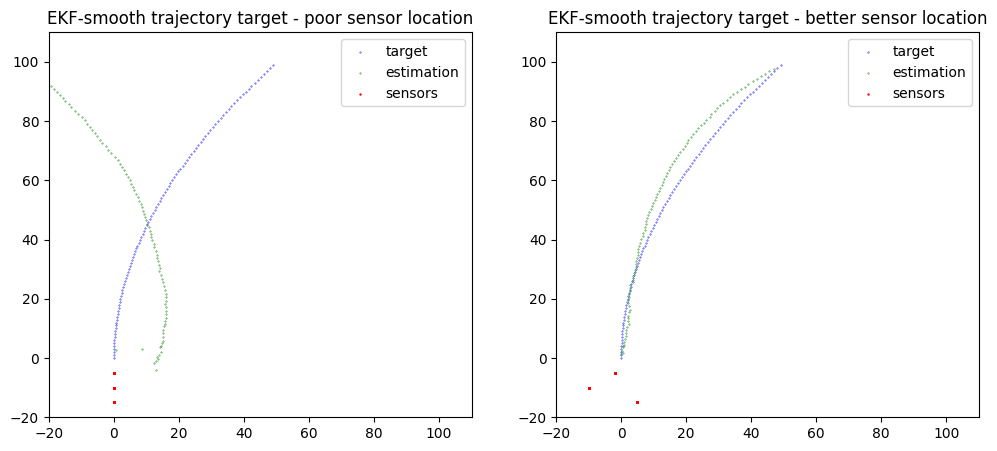

In [82]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('EKF-smooth trajectory target - poor sensor location')
plt.scatter(target_5[:,0,:],target_5[:,1,:],c='blue',s=0.1,label='target')
plt.scatter(est_5[:,0,:],est_5[:,1,:],c='green',s=0.1,label='estimation')
plt.scatter(sensors_5[:,0,:],sensors_5[:,1,:],c='red',s=0.5,label='sensors')
plt.xlim(-20,110)
plt.ylim(-20,110)
plt.legend()

plt.subplot(1,2,2)
plt.title('EKF-smooth trajectory target - better sensor location')
plt.scatter(target_6[:,0,:],target_6[:,1,:],c='blue',s=0.1,label='target')
plt.scatter(est_6[:,0,:],est_6[:,1,:],c='green',s=0.1,label='estimation')
plt.scatter(sensors_6[:,0,:],sensors_6[:,1,:],c='red',s=0.5,label='sensors')
plt.xlim(-20,110)
plt.ylim(-20,110)
plt.legend()
plt.show()

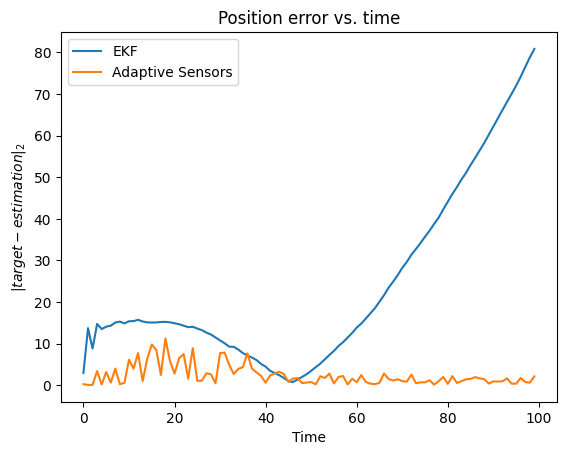

In [83]:
plt.title('Position error vs. time')
plt.xlabel('Time')
plt.ylabel(r'$|target-estimation|_2$')
plt.plot(cost_5,label='EKF')
plt.plot(cost_2,label='Adaptive Sensors')
plt.legend()
plt.show()



$$u \in (-0.1,0.1)^2   a \in (-0.05,0.05)^2$$


### Settings 1 
* target in the middle of sensors, with high speed
$$x_s = \left[\begin{array}{cc}
  -20.&20.&0&0.\\
  -20.&-20.&0.&0.\\
  20.&0.&0.&0.\end{array}\right]$$
$$x_t = [-0.7193, -0.4033,2,-2]$$
<br/>
<img src="settings_1_T=5.gif" width="850" align="center"><br/>
<img src="settings_1_1.png" width="350" align="center">
<img src="settings_1_2.png" width="350" align="center">



### Settings 2
* target in the middle of sensors, with zero speed
$$x_s = \left[\begin{array}{cc}
  -20.&20.&0&0.\\
  -20.&-20.&0.&0.\\
  20.&0.&0.&0.\end{array}\right]$$
$$x_t = [-0.7193, -0.4033,0,0]$$
<br/>
<img src="settings_2_T=5.gif" width="850" align="center"><br/>
<img src="settings_2_1.png" width="320" align="center">
<img src="settings_2_2.png" width="320" align="center">

### Settings 3
* target is far out of hull of sensors, with high velocity(bad initialization, difficult to estimate)
<br/>
$$x_s = \left[\begin{array}{cc}
  -2.&2.&0&0.\\
  -2.&-2.&0.&0.\\
  2.&0.&0.&0.\end{array}\right]$$
$$x_t = [17, -4,2,-2]$$
<br/>
<img src="settings_3_T=5.gif" width="850" align="center"><br/>
<img src="settings_3_1.png" width="320" align="center">
<img src="settings_3_2.png" width="320" align="center">

### Settings 4(Similar to Setting 2 but with velocity estimation)
* target in the middle of sensors, with zero speed, estimate with velocity
$$x_s = \left[\begin{array}{cc}
  -20.&20.&0&0.\\
  -20.&-20.&0.&0.\\
  20.&0.&0.&0.\end{array}\right]$$
$$x_t = [-0.7193, -0.4033,0,0]$$
<br/>
<img src="settings_4_T=5.gif" width="850" align="center"><br/>
<img src="settings_4_1.png" width="320" align="center">
<img src="settings_4_2.png" width="320" align="center">


### Settings 5(Similar to Settings 1 but with velocity estimation)
* target in the middle of sensors, with high speed, estimate with velocity
$$x_s = \left[\begin{array}{cc}
  -20.&20.&0&0.\\
  -20.&-20.&0.&0.\\
  20.&0.&0.&0.\end{array}\right]$$
$$x_t = [-0.7193, -0.4033,2,-2]$$
<br/>
<img src="settings_5_T=5.gif" width="850" align="center"><br/>
<img src="settings_5_1.png" width="350" align="center">
<img src="settings_5_2.png" width="350" align="center">



In [979]:

w4 = torch.tensor([0.33,0,0.34,0,0.33])

frames_4 = tracking_smooth(K,5,lr_s,lr_t,w4,position_only=False)

KeyboardInterrupt: 

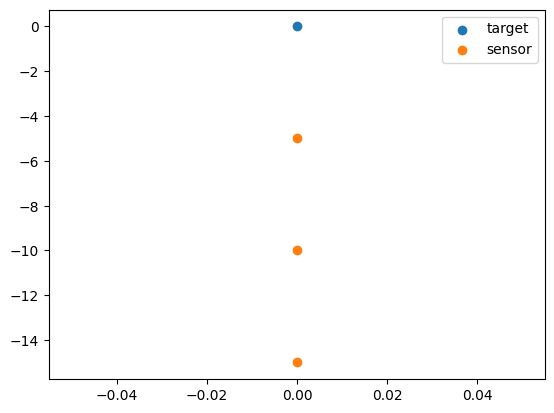

In [244]:
plt.scatter(frames_4[0]['target'][:,0],frames_4[0]['target'][:,1],label='target')
plt.scatter(frames_4[0]['sensor'][:,0],frames_4[0]['sensor'][:,1],label='sensor')
plt.legend()
plt.show()

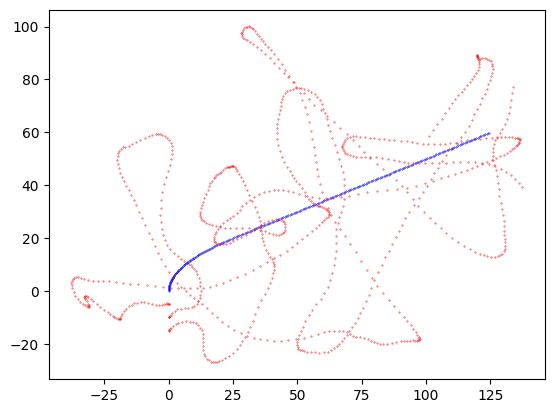

In [245]:
for frame in frames_4:
    plt.scatter(frame['target'][:,0],frame['target'][:,1],c='blue',s=0.1)
    plt.scatter(frame['sensor'][:,0],frame['sensor'][:,1],c='red',s=0.1)

In [940]:
frames_5[150]

{'target': array([[25. , 20. ,  0.5,  0.2]]),
 'sensor': array([[ -3.,  -5.,   0.,   0.],
        [  0., -10.,   0.,   0.],
        [ 30., -15.,   0.,   0.]]),
 'est': array([[ 45.68490359, -31.41856267,   2.02745588,   2.89982264]]),
 'mse': 3071.7338233648857,
 'k': 150}

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x2c16737f0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 

KeyboardInterrupt



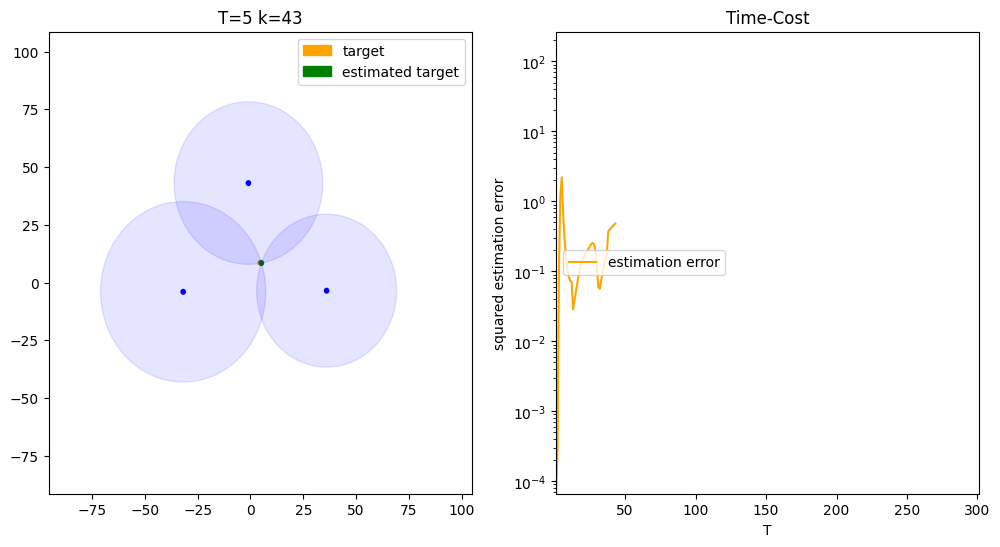

In [938]:
cost_4,v4 = extract_costs(frames_4)
plotgif(5,frames_4,cost_4,v4,rect,'smooth target')

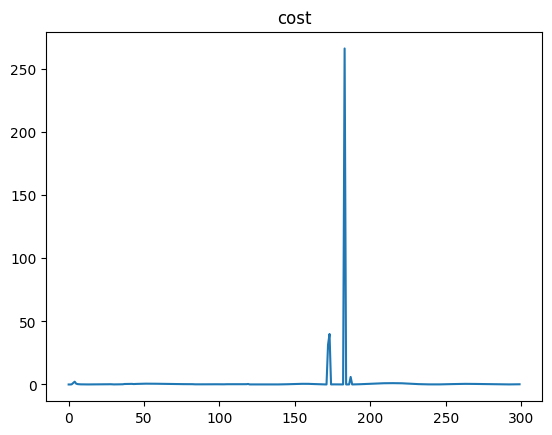

In [247]:
plt.title('cost')
plt.plot(cost_4)

In [131]:
cost_1,v1 = extract_costs(frames_1)
cost_2,v2 = extract_costs(frames_2)
cost_3,v3 = extract_costs(frames_3)
cost_0,v0 = extract_costs(frames_0)

In [132]:

plotgif(5,frames_0,cost_0,v0,rect,'weight_settings_0')
plotgif(5,frames_1,cost_1,v1,rect,'weight_settings_1')
plotgif(5,frames_2,cost_2,v2,rect,'weight_settings_2')
plotgif(5,frames_3,cost_3,v3,rect,'weight_settings_3')

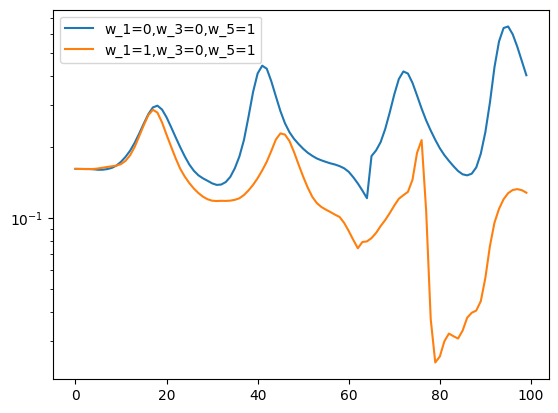

In [133]:
#plt.plot(cost_0,label='w_1=1,w_3=0,w_5=0')
plt.plot(cost_1,label='w_1=0,w_3=0,w_5=1')
plt.plot(cost_2,label='w_1=1,w_3=0,w_5=1')
#plt.plot(cost_3,label='w_1=1,w_3=1,w_5=1')
plt.yscale('log')
plt.legend()
plt.show()

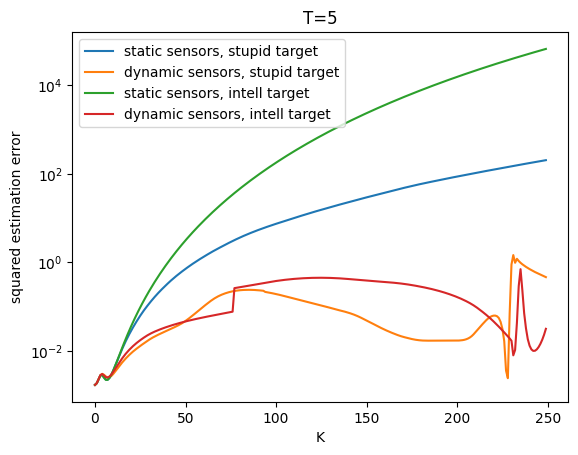

In [4068]:
plt.plot(cost_sn,label='static sensors, stupid target')
plt.plot(cost_dn,label='dynamic sensors, stupid target')
plt.plot(cost_si,label='static sensors, intell target')
plt.plot(cost_di,label='dynamic sensors, intell target')
plt.xlabel('K')
plt.ylabel('squared estimation error')
plt.yscale('log')
plt.title('T=5')
plt.legend()
plt.show()

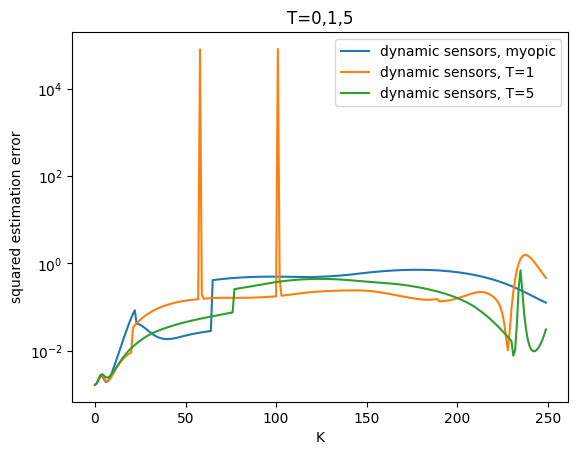

In [4069]:
plt.plot(cost_di_0,label='dynamic sensors, myopic')
plt.plot(cost_di_1,label='dynamic sensors, T=1')
plt.plot(cost_di,label='dynamic sensors, T=5')
plt.xlabel('K')
plt.ylabel('squared estimation error')
plt.title('T=0,1,5')
plt.yscale('log')
plt.legend()
plt.show()

In [1589]:
transition = transition_d1

range_u_s = [-0.1,0.1]
range_u_t = [-0.01,0.01]

s2 = 0.01
lr_t = 0.01
lr_s = 0.05
M = 3
xs = torch.randn((M,2))*3 - 20


xt = torch.randn((1,2))


T = 5
K = 100



In [1590]:
frames_t_5 = tracking(K,T,xs,xt,lr_s,lr_t) 

In [1591]:
frames_t_10 = tracking(K,10,xs,xt,lr_s,lr_t) 

In [1592]:
frames_t_0 = tracking(K,0,xs,xt,lr_s,lr_t)

In [1593]:
cost_t_0 = []
for frame in frames_t_0:
    cost_t_0.append(frame['cost'])
    

    
cost_t_10 = []
for frame in frames_t_10:
    cost_t_10.append(frame['cost'])

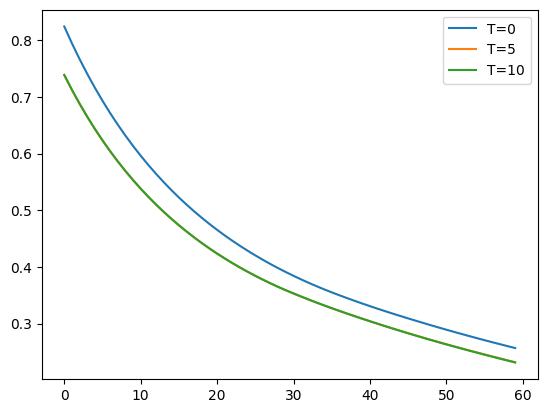

In [1598]:
plt.plot(cost_t_0[-60:],label='T=0')
plt.plot(cost_t_5[-60:],label='T=5')
plt.plot(cost_t_10[-60:],label='T=10')
plt.legend()
plt.show()

In [1599]:
mse_t_0 = []
for frame in frames_t_0:
    mse_t_0.append(frame['mse'])
    
mse_t_5 = []
for frame in frames_t_5:
    mse_t_5.append(frame['mse'])
    
mse_t_10 = []
for frame in frames_t_10:
    mse_t_10.append(frame['mse'])

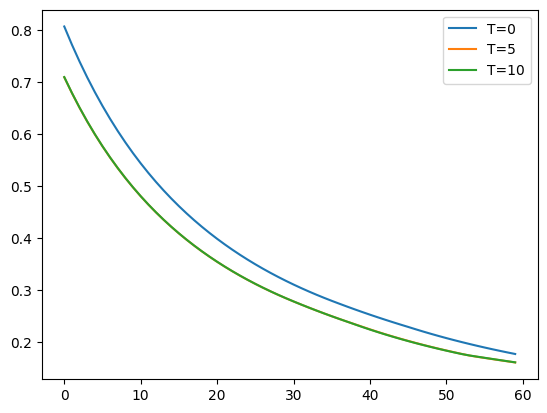

In [1603]:
plt.plot(mse_t_0[-60:],label='T=0')
plt.plot(mse_t_5[-60:],label='T=5')
plt.plot(mse_t_10[-60:],label='T=10')
plt.legend()
plt.show()

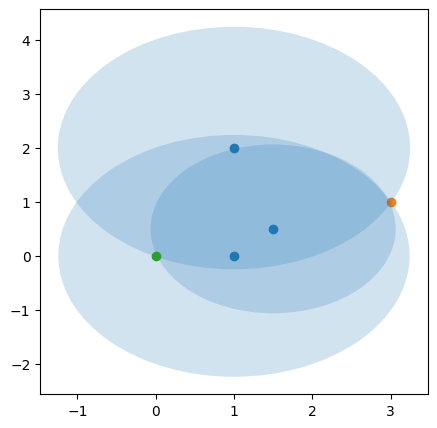

In [3960]:
fig,ax = plt.subplots(figsize=(5,5))
plt.scatter(sensors[:,0],sensors[:,1])
plt.scatter(target[:,0],target[:,1])
ax.add_patch(Circle(sensors[0],obs[0][0],alpha=0.2))
ax.add_patch(Circle(sensors[1],obs[0][1],alpha=0.2))
ax.add_patch(Circle(sensors[2],obs[0][2],alpha=0.2))

idx_sensor = np.argmin(((sensors-target)**2).sum(axis=1))
symmetric_point = 2*sensors[[idx_sensor]]-target
plt.scatter(symmetric_point[0][0],symmetric_point[0][1])

In [4024]:
est,err = estimate_range_sensors(sensors,obs,[0,0])

[[3.00148506 0.99374304]]


In [4025]:
est

array([[3.00148506, 0.99374304]])

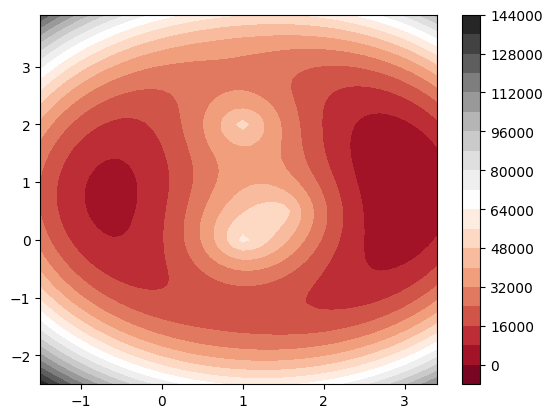

In [4026]:
sensors = np.array([[1,0],[1.5,0.5],[1,2]])
target = np.array([[3,1]])
s2 = 0.0001
alpha=0.05
mu,cov,d_mu,d_cov,inv_cov = stats_2d_range(sensors,target)
obs = simu_2d_range(mu,cov,size=3)

X,Y = np.mgrid[-1.5:3.5:0.1,-2.5:4:0.1]
N,M = X.shape
Z = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        Z[i,j] = negloglikelihood((X[i,j],Y[i,j]),obs[0],lambda x:stats_2d_range(sensors,x))
        
        
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()
plt.show()

In [4019]:
X[45,35]

3.0

In [1720]:
#experiment
from scipy.stats import multivariate_normal,uniform

mu_x = np.array([3,10,2,-1])
cov_x = np.array([[0.1,0,0,0],[0,0.02,0,0],[0,0,0.1,0],[0,0,0,0.3]])
d = multivariate_normal(mean=mu_x,cov=cov_x)
l = np.array([0,0,-1,-2])
h = np.array([0,0,1,2])
X = np.zeros((4,10000))
X0 = d.rvs(10000).T
for i in range(10000):
    #x0 = d.rvs(1).reshape(-1,1)
    x0 = X0[:,[i]]
    a = np.random.uniform(low=l, high=h, size=(1,4))
    X[:,[i]] = (A@x0+B@a.T)
    
np.cov(X)

array([[ 1.01839535e-01, -7.07418886e-05,  1.01387366e-01,
        -8.71184392e-04],
       [-7.07418886e-05,  1.92697856e-02, -2.27708378e-04,
         1.50924702e-02],
       [ 1.01387366e-01, -2.27708378e-04,  5.35805903e-01,
        -1.26458325e-02],
       [-8.71184392e-04,  1.50924702e-02, -1.26458325e-02,
         1.66141416e+00]])

In [3464]:
l = np.array([0,0,-0.01,-0.01])
h = np.array([0,0,0.01,0.01])
err_combined = []
err_obs = []

expected_var_a = (1/12)*B.numpy()@np.diag((h-l)**2)@B.numpy().T
pv = []
mlev = []
for i in range(1):
    np.random.seed(10) ;
    test_s = -10+np.random.random((3,4))
    test_t = np.random.random((1,4))
    test_s[:,2:] = 0
    test_t[:,2:] = 1
    
    
    #read sensors
    mu,cov,_,_,_ = stats_2d_range(test_s[:,:2],test_t[:,:2])
    obs_prev = simu_2d_range(mu,cov,size=1)

    
    for k in range(100):
        #next state
        a = np.random.uniform(low=l, high=h, size=(1,4))
        #a = np.zeros((1,4))
        test_t = test_t@A.numpy()+a@B.numpy()
        test_s_new = test_s@A.numpy()
        
        #read sensors
        mu,cov,_,_,_ = stats_2d_range(test_s[:,:2],test_t[:,:2])
        obs = simu_2d_range(mu,cov,size=1)
        
        
        
        
        est_pred = minimize(negloglikelihood_4d,x0=(0,0,0,0),args=(test_s,test_s,obs,obs_prev)
               ,method='nelder-mead',options={'xatol': 1e-8, 'disp': False}).x.reshape(1,-1)
        est_pred = est_pred@A.numpy()
        
        J1 = fisher_information(*stats_4d_range_0(test_s,est_pred)) + fisher_information(*stats_4d_range_1(test_s_new,est_pred))
        J1 = np.linalg.inv(A.numpy()@np.linalg.inv(J1)@A.numpy().T + expected_var_a)
       
        
        est_o = np.zeros((1,4))
        est_o[:,:2] = minimize(negloglikelihood,x0=(0,0),args=(obs,lambda x:stats_2d_range(test_s[:,:2],x)),method='nelder-mead',options={'xatol': 1e-8, 'disp': False}).x.reshape(1,-1)

        
        test_s = test_s_new
        obs_prev = obs
        
        
        J2 = np.zeros((4,4))
        J2[:2,:2] = fisher_information(*stats_2d_range(test_s[:,:2],est_o[:,:2]))

       
        P = np.linalg.inv(J1+J2)
        
        est_combined = (P@(J1@est_pred.T + J2@est_o.T)).T
        
        pv.append(np.trace(P))
        mlev.append(np.trace(np.linalg.inv(J2[:2,:2])))
        
        mse_combined = np.sum((est_combined[:,:2]-test_t[:,:2])**2)
        err_combined.append(mse_combined)
        #estimator from measurement
        mse_obs = np.sum((est_o[:,:2] - test_t[:,:2])**2)
        err_obs.append(mse_obs)
        print(k,test_t,est_pred,est_o,est_combined)

0 [[1.00812601 1.51433802 1.00835548 1.00429152]] [[ 3.59265849 -1.45760486 -1.02008261  8.45294973]] [[  5.89663595 -11.91758007   0.           0.        ]] [[ 6.64759788 -6.2052616  -1.02008261  8.45294973]]
1 [[2.0152149  2.52037087 1.0058223  1.00777419]] [[  7.15815152 -13.04859978   1.25783435  -5.15179456]] [[  7.28892143 -12.24830638   0.           0.        ]] [[  7.22933131 -12.67288581   1.25783435  -5.15179456]]
2 [[3.02221487 3.52827644 1.00817764 1.00803695]] [[ 7.76023527 -3.57281551  0.55531723  9.21976395]] [[  8.68200583 -12.57702234   0.           0.        ]] [[ 9.36395699 -7.95772456  0.55531723  9.21976395]]
3 [[4.03344473 4.53652987 1.0142821  1.0084699 ]] [[ 10.30976305  -9.92757401   5.88538166 -12.04277146]] [[ 10.07783629 -12.90460383   0.           0.        ]] [[ 10.30691583 -11.41601887   5.88538166 -12.04277146]]
4 [[5.04363143 5.54300676 1.00609129 1.0044839 ]] [[ 4.52291784  6.06654854 -5.77534909 15.31491783]] [[ 11.47152397 -13.22995099   0.          

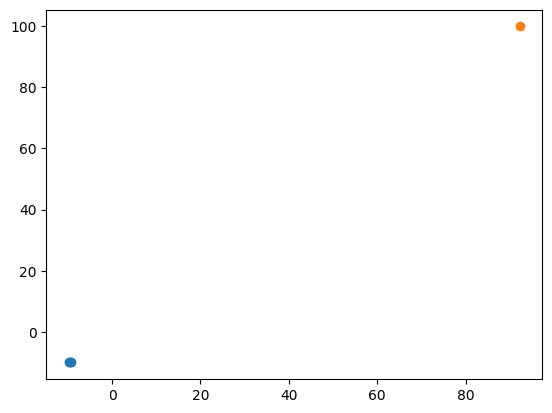

In [3465]:
plt.scatter(test_s[:,0],test_s[:,1])
plt.scatter(test_t[:,0],test_t[:,1])

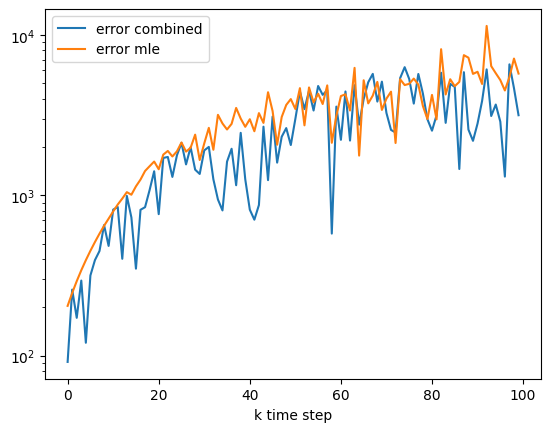

In [3466]:
plt.plot(err_combined,label='error combined')
plt.plot(err_obs,label='error mle')
plt.legend()
plt.yscale('log')
plt.xlabel('k time step')
plt.show()

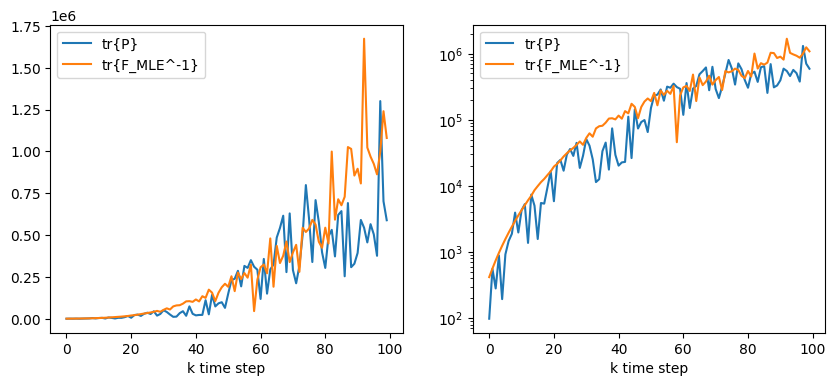

In [3467]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(pv,label='tr{P}')
plt.plot(mlev,label='tr{F_MLE^-1}')
plt.xlabel('k time step')
plt.legend()


plt.subplot(1,2,2)
plt.plot(pv,label='tr{P}')
plt.plot(mlev,label='tr{F_MLE^-1}')
plt.legend()
plt.xlabel('k time step')
plt.yscale('log')
plt.show()

In [164]:
l = np.array([-0.1,-0.1])
h = np.array([0.1,0.1])
err_combined = []
err_obs = []

expected_var_a = (1/12)*np.diag((h-l)**2)
pv = []
mlev = []
for i in range(1):
    np.random.seed(10) ;
    test_s = 3*np.random.random((3,4))[:,:2]
    test_t = np.random.random((1,4))[:,:2]
    print(test_s,test_t)

    
    #read sensors
    mu,cov,_,_,_ = stats_2d_range(test_s,test_t)
    obs1 = simu_2d_range(mu,cov,size=1)
    est = minimize(negloglikelihood,x0=(0,0),args=(obs1,lambda x:stats_2d_range(test_s,x)),method='nelder-mead',options={'xatol': 1e-8, 'disp': False}).x.reshape(1,-1)


    #variance bound of estimator
    F_MLE = fisher_information(*stats_2d_range(test_s,est))
    P = np.linalg.inv(F_MLE)    
    
    for k in range(100):
        #next state
        a = np.random.uniform(low=l, high=h, size=(1,2))
        test_t = test_t+a
        
        P = P + expected_var_a
        F = np.linalg.inv(P)
        J1 = F
       
        if k == 0:
            est_pred = est
        else:
            est_pred = est_combined.copy()
        
        #read sensors
        mu,cov,_,_,_ = stats_2d_range(test_s,test_t)
        obs = simu_2d_range(mu,cov,size=1)
        res = minimize(negloglikelihood,x0=est,args=(obs,lambda x:stats_2d_range(test_s,x)),method='nelder-mead',options={'xatol': 1e-8, 'disp': False})
        est = res.x.reshape(1,-1)
    
        F_MLE = fisher_information(*stats_2d_range(test_s,est))
    
        J2 = F_MLE
        
        est_obs = est
        
        #combine estimator
        P = np.linalg.inv(J1+J2)
        est_combined = (P@(J1@est_pred.T+J2@est_obs.T)).T

        
        

        pv.append(np.trace(P))
        mlev.append(np.trace(np.linalg.inv(F_MLE)))
        
        mse_combined = np.sum((est_combined-test_t)**2)
        err_combined.append(mse_combined)
        #estimator from measurement
        mse_obs = np.sum((est_obs - test_t)**2)
        err_obs.append(mse_obs)

[[2.31396193 0.06225585]
 [1.49552104 0.67438994]
 [0.50733251 0.26501944]] [[0.00394827 0.51219226]]


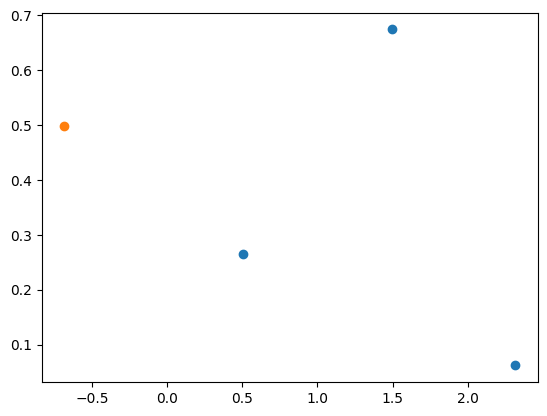

In [3362]:
plt.scatter(test_s[:,0],test_s[:,1])
plt.scatter(test_t[:,0],test_t[:,1])

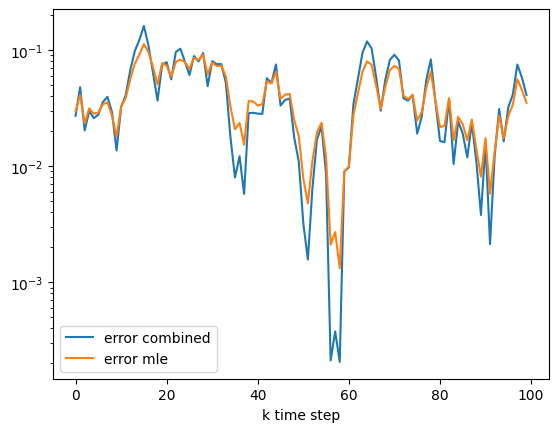

In [3363]:
plt.plot(err_combined,label='error combined')
plt.plot(err_obs,label='error mle')
plt.legend()
plt.yscale('log')
plt.xlabel('k time step')
plt.show()

In [3364]:
k = np.array([[100,100]]).T

np.linalg.inv(J1+J2)@(J2@k)

array([[61.44121394],
       [13.14152265]])

In [2907]:
e = np.array([[1,0,0,0],[0,1,0,0]]).T


np.random.seed(10) ;
test_s = 3*np.random.random((3,4))


test_t_pre = np.random.random((1,4))
test_t_pre[:,2:] = 10

test_t = test_t_pre@A.numpy()

In [3268]:
test_s_prev = 3*np.random.random((3,4))


a_s_prev = np.random.random((3,4))
a_s_prev[:,:2] = 0

test_s = test_s_prev@A.numpy()+a_s_prev@B.numpy()

test_t_prev = np.random.random((1,4))
test_t_prev[:,2:] = 1

a_t_prev = 0.01*np.random.random((1,4))
a_t_prev[:,:2] = 0

test_t = test_t_prev@A.numpy()+a_t_prev@B.numpy()

mu_prev,cov_prev,_,_,_ = stats_4d_range_0(test_s_prev,test_t_prev)
obs_prev = simu_2d_range(mu_prev,cov_prev,size=1)

mu,cov,_,_,_ = stats_4d_range_0(test_s,test_t)
obs = simu_2d_range(mu,cov,size=1)


In [3269]:
est = minimize(negloglikelihood_4d,x0=(0,0,0,0),args=(test_s,test_s_prev,obs,obs_prev)
               ,method='nelder-mead',options={'xatol': 1e-8, 'disp': False}).x.reshape(1,-1)
est

array([[0.4927138 , 0.49176649, 0.97109464, 1.02347838]])

In [3270]:
test_t_prev

array([[0.64890515, 0.501746  , 1.        , 1.        ]])

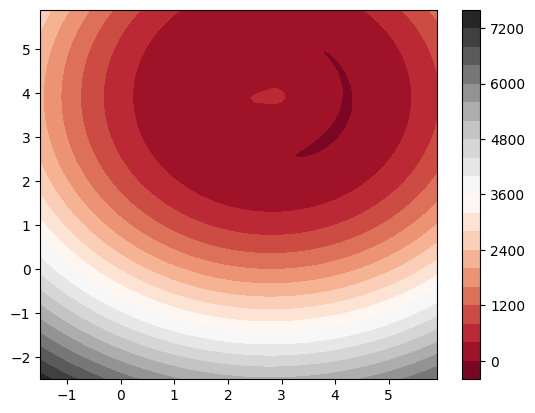

In [3006]:
X,Y = np.mgrid[-1.5:6:0.1,-2.5:6:0.1]
N,M = X.shape
Z = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        Z[i,j] = negloglikelihood_4d(np.array((0.055,0.448,X[i,j],Y[i,j])),test_s,test_s_prev,obs,obs_prev)
        
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()
plt.show()

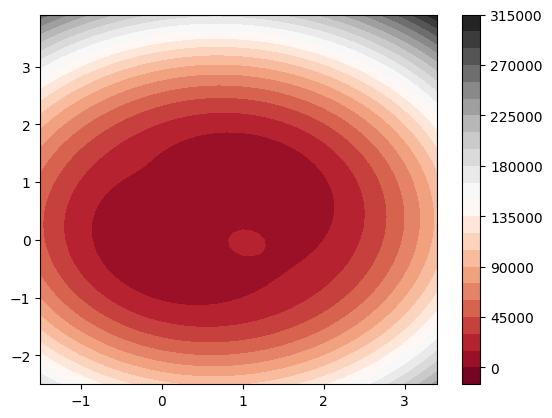

In [4070]:
sensors = np.array([[1,0],[1.,0.],[0,1]])
target = np.array([[0,0]])
s2 = 0.0001
alpha=0.05
mu,cov,d_mu,d_cov,inv_cov = stats_2d_range(sensors,target)
obs = simu_2d_range(mu,cov,size=3)

X,Y = np.mgrid[-1.5:3.5:0.1,-2.5:4:0.1]
N,M = X.shape
Z = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        Z[i,j] = negloglikelihood((X[i,j],Y[i,j]),obs[0],lambda x:stats_2d_range(sensors,x))
        
        
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()
plt.show()

In [4128]:
sensors = np.array([[1.,0,0,0],[1.,0.,0,0],[-1,0,0,0]])
target = np.array([[0.01,0.01,0,0.]])
transition = transition_d2
u,losses = greedymove(torch.tensor(sensors),torch.tensor(target),lr_s,is_target=False,maxi = False)
u

tensor([[[ 0.0000,  0.0000, -0.0959, -0.0851],
         [ 0.0000,  0.0000, -0.0959, -0.0851],
         [ 0.0000,  0.0000,  0.0959, -0.0851]]])

In [66]:
sensors = np.array([[1.,0,0,0],[0.,1.,0,0],[-1,0,0,0]])
target = np.array([[0.01,0.01,0,0.]])
w =torch.tensor([1.])
#,[1.,0.,0,0]
#,[0.,0.,0,0]
u_s = torch.tensor([[[0.,0.,0,0],[0.,0.,0,0],[0,0,0,0]]],requires_grad=True)
opt = optim.Adam([u_s],lr = lr_s)
loss = forward(torch.tensor(sensors),torch.tensor(target),u_s,torch.zeros((1,1,4)),torch.zeros((1,4)),[0,0,0,0],w)
loss.backward()
opt.step()
print(u_s)

tensor([[[ 0.0000,  0.0000, -0.0496,  0.0451],
         [ 0.0000,  0.0000,  0.0499, -0.0499],
         [ 0.0000,  0.0000,  0.0496, -0.0499]]], requires_grad=True)


In [4123]:
u_s_o = np.array([[ 0.0000,  0.0000, -0.0500, -0.0500],
         [ 0.0000,  0.0000, -0.0500, -0.0500],
         [ 0.0000,  0.0000,  0.0500, -0.0500]])

x_s_o = sensors@A.numpy()-u_s_o@B.numpy()

crlb(*stats_2d_range(x_s_o[:,:2],target[:,:2]))

1.5925785971209978

In [4124]:
u_s_1 = np.array([[ 0.0000,  0.0000, -0.0500, -0.0500],
         [ 0.0000,  0.0000, -0.0500, 0.0500],
         [ 0.0000,  0.0000,  0.0500, -0.0500]])

x_s_1 = sensors@A.numpy()-u_s_1@B.numpy()

crlb(*stats_2d_range(x_s_1[:,:2],target[:,:2]))

0.07581882136656516

In [4112]:
u_s_2 = np.array([[ 0.0000,  0.0000, -0.0278,  0.0000],
         [ 0.0000,  0.0000, -0.01,  -0.0278],
         [ 0.0000,  0.0000,  0.0000, -0.0417]])

x_s_2 = sensors@A.numpy()+u_s_2@B.numpy()

crlb(*stats_2d_range(x_s_2[:,:2],target[:,:2]))

0.00015144938631500045

In [ ]:
A.numpy()

In [2772]:
dmu = A.numpy()@e@(e.T@(test_s-A.numpy()@test_t))/mu_x
dmu

array([[0.7997159 , 0.05919215, 0.99636459],
       [0.60037862, 0.99824661, 0.08519152],
       [0.7997159 , 0.05919215, 0.99636459],
       [0.60037862, 0.99824661, 0.08519152]])

In [852]:

from __future__ import (absolute_import, division, unicode_literals)

from copy import deepcopy
from math import log, exp, sqrt
import sys
import numpy as np
from numpy import dot, zeros, eye
import scipy.linalg as linalg
from filterpy.stats import logpdf
from filterpy.common import pretty_str, reshape_z


class ExtendedKalmanFilter(object):

    """ Implements an extended Kalman filter (EKF). You are responsible for
    setting the various state variables to reasonable values; the defaults
    will  not give you a functional filter.

    You will have to set the following attributes after constructing this
    object for the filter to perform properly. Please note that there are
    various checks in place to ensure that you have made everything the
    'correct' size. However, it is possible to provide incorrectly sized
    arrays such that the linear algebra can not perform an operation.
    It can also fail silently - you can end up with matrices of a size that
    allows the linear algebra to work, but are the wrong shape for the problem
    you are trying to solve.

    Parameters
    ----------

    dim_x : int
        Number of state variables for the Kalman filter. For example, if
        you are tracking the position and velocity of an object in two
        dimensions, dim_x would be 4.

        This is used to set the default size of P, Q, and u

    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.

    Attributes
    ----------
    x : numpy.array(dim_x, 1)
        State estimate vector

    P : numpy.array(dim_x, dim_x)
        Covariance matrix

    x_prior : numpy.array(dim_x, 1)
        Prior (predicted) state estimate. The *_prior and *_post attributes
        are for convienence; they store the  prior and posterior of the
        current epoch. Read Only.

    P_prior : numpy.array(dim_x, dim_x)
        Prior (predicted) state covariance matrix. Read Only.

    x_post : numpy.array(dim_x, 1)
        Posterior (updated) state estimate. Read Only.

    P_post : numpy.array(dim_x, dim_x)
        Posterior (updated) state covariance matrix. Read Only.

    R : numpy.array(dim_z, dim_z)
        Measurement noise matrix

    Q : numpy.array(dim_x, dim_x)
        Process noise matrix

    F : numpy.array()
        State Transition matrix

    H : numpy.array(dim_x, dim_x)
        Measurement function

    y : numpy.array
        Residual of the update step. Read only.

    K : numpy.array(dim_x, dim_z)
        Kalman gain of the update step. Read only.

    S :  numpy.array
        Systen uncertaintly projected to measurement space. Read only.

    z : ndarray
        Last measurement used in update(). Read only.

    log_likelihood : float
        log-likelihood of the last measurement. Read only.

    likelihood : float
        likelihood of last measurment. Read only.

        Computed from the log-likelihood. The log-likelihood can be very
        small,  meaning a large negative value such as -28000. Taking the
        exp() of that results in 0.0, which can break typical algorithms
        which multiply by this value, so by default we always return a
        number >= sys.float_info.min.

    mahalanobis : float
        mahalanobis distance of the innovation. E.g. 3 means measurement
        was 3 standard deviations away from the predicted value.

        Read only.

    Examples
    --------

    See my book Kalman and Bayesian Filters in Python
    https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
    """

    def __init__(self, dim_x, dim_z, dim_u=0):

        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dim_u = dim_u

        self.x = zeros((dim_x, 1)) # state
        self.P = eye(dim_x)        # uncertainty covariance
        self.B = eye(dim_x)                 # control transition matrix
        self.F = eye(dim_x)     # state transition matrix
        self.R = eye(dim_z)        # state uncertainty
        self.Q = eye(dim_x)        # process uncertainty
        self.y = zeros((dim_z, 1)) # residual

        z = np.array([None]*self.dim_z)
        self.z = reshape_z(z, self.dim_z, self.x.ndim)

        # gain and residual are computed during the innovation step. We
        # save them so that in case you want to inspect them for various
        # purposes
        self.K = np.zeros(self.x.shape) # kalman gain
        self.y = zeros((dim_z, 1))
        self.S = np.zeros((dim_z, dim_z))   # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty

        # identity matrix. Do not alter this.
        self._I = np.eye(dim_x)

        self._log_likelihood = log(sys.float_info.min)
        self._likelihood = sys.float_info.min
        self._mahalanobis = None

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def predict_update(self, z, HJacobian, Hx, args=(), hx_args=(), u=0):
        """ Performs the predict/update innovation of the extended Kalman
        filter.

        Parameters
        ----------

        z : np.array
            measurement for this step.
            If `None`, only predict step is perfomed.

        HJacobian : function
           function which computes the Jacobian of the H matrix (measurement
           function). Takes state variable (self.x) as input, along with the
           optional arguments in args, and returns H.

        Hx : function
            function which takes as input the state variable (self.x) along
            with the optional arguments in hx_args, and returns the measurement
            that would correspond to that state.

        args : tuple, optional, default (,)
            arguments to be passed into HJacobian after the required state
            variable.

        hx_args : tuple, optional, default (,)
            arguments to be passed into Hx after the required state
            variable.

        u : np.array or scalar
            optional control vector input to the filter.
        """
        #pylint: disable=too-many-locals

        if not isinstance(args, tuple):
            args = (args,)

        if not isinstance(hx_args, tuple):
            hx_args = (hx_args,)

        if np.isscalar(z) and self.dim_z == 1:
            z = np.asarray([z], float)

        F = self.F
        B = self.B
        P = self.P
        Q = self.Q
        R = self.R
        x = self.x

        H = HJacobian(x, *args)

        # predict step
        self.predict_x(u)
        
        P = dot(F, P).dot(F.T) + Q

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

        # update step
        PHT = dot(P, H.T)
        self.S = dot(H, PHT) + R
        self.SI = linalg.inv(self.S)
        self.K = dot(PHT, self.SI)
       
        self.y = z - Hx(x, *hx_args)
        self.x = x + dot(self.K, self.y[:,None]).T
        
        I_KH = self._I - dot(self.K, H)
        self.P = dot(I_KH, P).dot(I_KH.T) + dot(self.K, R).dot(self.K.T)

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None

    def update(self, z, HJacobian, Hx, R=None, args=(), hx_args=(),
               residual=np.subtract):
        """ Performs the update innovation of the extended Kalman filter.

        Parameters
        ----------

        z : np.array
            measurement for this step.
            If `None`, posterior is not computed

        HJacobian : function
           function which computes the Jacobian of the H matrix (measurement
           function). Takes state variable (self.x) as input, returns H.

        Hx : function
            function which takes as input the state variable (self.x) along
            with the optional arguments in hx_args, and returns the measurement
            that would correspond to that state.

        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise for this
            one call, otherwise  self.R will be used.

        args : tuple, optional, default (,)
            arguments to be passed into HJacobian after the required state
            variable. for robot localization you might need to pass in
            information about the map and time of day, so you might have
            `args=(map_data, time)`, where the signature of HCacobian will
            be `def HJacobian(x, map, t)`

        hx_args : tuple, optional, default (,)
            arguments to be passed into Hx function after the required state
            variable.

        residual : function (z, z2), optional
            Optional function that computes the residual (difference) between
            the two measurement vectors. If you do not provide this, then the
            built in minus operator will be used. You will normally want to use
            the built in unless your residual computation is nonlinear (for
            example, if they are angles)
        """

        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if not isinstance(args, tuple):
            args = (args,)

        if not isinstance(hx_args, tuple):
            hx_args = (hx_args,)

        if R is None:
            R = self.R
        elif np.isscalar(R):
            R = eye(self.dim_z) * R

        if np.isscalar(z) and self.dim_z == 1:
            z = np.asarray([z], float)

        H = HJacobian(self.x, *args)

        PHT = dot(self.P, H.T)
        
        self.S = dot(H, PHT) + R
        self.K = PHT.dot(linalg.inv(self.S))
        
        
        hx = Hx(self.x, *hx_args)
        self.y = residual(z, hx)
        self.x = self.x + dot(self.K, self.y[:,None]).T
        
        # P = (I-KH)P(I-KH)' + KRK' is more numerically stable
        # and works for non-optimal K vs the equation
        # P = (I-KH)P usually seen in the literature.
        I_KH = self._I - dot(self.K, H)
        
        self.P = dot(I_KH, self.P).dot(I_KH.T) + dot(self.K, R).dot(self.K.T)

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def predict_x(self, u=0):
        """
        Predicts the next state of X. If you need to
        compute the next state yourself, override this function. You would
        need to do this, for example, if the usual Taylor expansion to
        generate F is not providing accurate results for you.
        """
        self.x = self.x@self.F+u@self.B
  

    def predict(self, u=0):
        """
        Predict next state (prior) using the Kalman filter state propagation
        equations.

        Parameters
        ----------

        u : np.array
            Optional control vector. If non-zero, it is multiplied by B
            to create the control input into the system.
        """

        self.predict_x(u)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

    @property
    def log_likelihood(self):
        """
        log-likelihood of the last measurement.
        """

        if self._log_likelihood is None:
            self._log_likelihood = logpdf(x=self.y, cov=self.S)
        return self._log_likelihood

    @property
    def likelihood(self):
        """
        Computed from the log-likelihood. The log-likelihood can be very
        small,  meaning a large negative value such as -28000. Taking the
        exp() of that results in 0.0, which can break typical algorithms
        which multiply by this value, so by default we always return a
        number >= sys.float_info.min.
        """
        if self._likelihood is None:
            self._likelihood = exp(self.log_likelihood)
            if self._likelihood == 0:
                self._likelihood = sys.float_info.min
        return self._likelihood

    @property
    def mahalanobis(self):
        """
        Mahalanobis distance of innovation. E.g. 3 means measurement
        was 3 standard deviations away from the predicted value.

        Returns
        -------
        mahalanobis : float
        """
        if self._mahalanobis is None:
            self._mahalanobis = sqrt(float(dot(dot(self.y.T, self.SI), self.y)))
        return self._mahalanobis

    def __repr__(self):
        return '\n'.join([
            'KalmanFilter object',
            pretty_str('x', self.x),
            pretty_str('P', self.P),
            pretty_str('x_prior', self.x_prior),
            pretty_str('P_prior', self.P_prior),
            pretty_str('F', self.F),
            pretty_str('Q', self.Q),
            pretty_str('R', self.R),
            pretty_str('K', self.K),
            pretty_str('y', self.y),
            pretty_str('S', self.S),
            pretty_str('likelihood', self.likelihood),
            pretty_str('log-likelihood', self.log_likelihood),
            pretty_str('mahalanobis', self.mahalanobis)
            ])